In [1]:
import pandas as pd
import numpy as np

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from gensim.models import Word2Vec

import spacy
import pandas as pd
import re

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


## Find the Important Features to Predict `Nutrition Density`

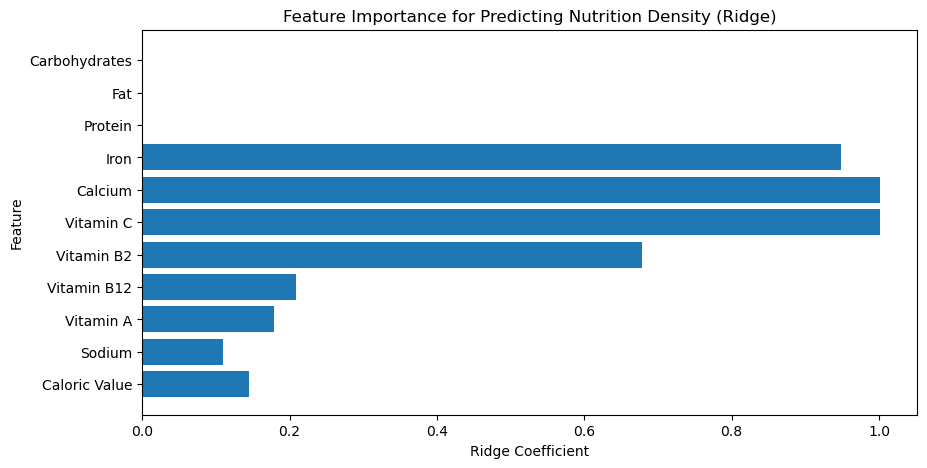


Evaluation of Ridge Features:
   - Mean Squared Error (MSE): 23.7932
   - R² Score: 0.9990

Comparison of Feature Selection Methods:
Ridge Features -> MSE: 23.7932, R²: 0.9990
Final feature set used: ['Caloric Value', 'Sodium', 'Vitamin A', 'Vitamin B12', 'Vitamin B2', 'Vitamin C', 'Calcium', 'Iron', 'Protein', 'Fat', 'Carbohydrates']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("clean_data_with_same_units.csv", index_col=0)

# Remove non-numeric columns
df_numeric = df.drop(columns=["food", "parsed_food"], errors="ignore")

# Define feature matrix (X) and target variable (y)
X = df_numeric.drop(columns=["Nutrition Density"])  # All nutrient features
y = df_numeric["Nutrition Density"]  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge regression with cross-validation
ridge = RidgeCV(alphas=[10, 50, 100, 500, 1000], cv=5)
ridge.fit(X_train, y_train)

# Store Ridge coefficients
ridge_coefs = pd.Series(ridge.coef_, index=X.columns)

# Select features with |coefficient| > 0.1
important_features = ridge_coefs[abs(ridge_coefs) > 0.1].index.tolist()

# Ensure key macronutrients are included
manual_features = ["Protein", "Fat", "Carbohydrates"]
for feature in manual_features:
    if feature not in important_features:
        important_features.append(feature)

# Save final selected features
nutrition_columns = important_features

# Feature importance visualization
plt.figure(figsize=(10, 5))
plt.barh(nutrition_columns, ridge_coefs[nutrition_columns])
plt.xlabel("Ridge Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance for Predicting Nutrition Density (Ridge)")
plt.show()

# Define function to evaluate feature sets
def evaluate_features(feature_list, name="Feature Set"):
    """
    Evaluate the predictive performance of a given feature set.
    """
    X_selected = X_train[feature_list]
    X_test_selected = X_test[feature_list]
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Compute Mean Squared Error (MSE) and R² score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nEvaluation of {name}:")
    print(f"   - Mean Squared Error (MSE): {mse:.4f}")
    print(f"   - R² Score: {r2:.4f}")
    
    return mse, r2

# Evaluate Ridge-selected features
ridge_mse, ridge_r2 = evaluate_features(nutrition_columns, "Ridge Features")

# Compare feature selection methods
print("\nComparison of Feature Selection Methods:")
print(f"Ridge Features -> MSE: {ridge_mse:.4f}, R²: {ridge_r2:.4f}")

# Final selected feature set
print("Final feature set used:", nutrition_columns)


## NLP - Extract Food Name Components

### Load Data & Save Original Dataset

In [6]:
path = 'clean_data_with_same_units.csv'
df = pd.read_csv(path, index_col=0)

# Store a copy of the original numeric nutrition data (before modifying df)
df_original = df.copy()

In [7]:
# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

def parse_food_name(food_name):
    """Extract meaningful components from food name using NLP."""
    doc = nlp(food_name.lower())
    return [token.lemma_ for token in doc if not token.is_stop]  # Lemmatization & stop-word removal

# Apply parsing
df["parsed_food"] = df["food"].apply(parse_food_name)

# Extract unique components
all_components = list(set(sum(df["parsed_food"].tolist(), [])))

In [55]:
import spacy
import pickle

# Save the function and extracted components
with open("parsed_food.pkl", "wb") as f:
    pickle.dump(parse_food_name, f)  # Save the function

with open("food_components.pkl", "wb") as f:
    pickle.dump(all_components, f)  # Save unique components

### Create a Binary Matrix for Food Components

In [9]:
import pandas as pd

# Create an empty DataFrame for one-hot encoding
component_df = pd.DataFrame(0, index=df.index, columns=all_components, dtype=int)

# Populate the matrix using parsed food names
for i, components in enumerate(df["parsed_food"]):
    for component in set(components):  # Avoid duplicate entries
        if component in component_df.columns:
            component_df.iat[i, component_df.columns.get_loc(component)] = 1

# Merge one-hot encoded matrix back with the original DataFrame
df = pd.concat([df, component_df], axis=1)

In [10]:
# Get numeric columns from the original dataset (excluding target variable)
all_nutrition_columns = df_original.select_dtypes(include=[np.number]).columns.drop("Nutrition Density")

# Convert numeric columns to float and fill NaNs with 0
df_original[all_nutrition_columns] = df_original[all_nutrition_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

### Using least squares regression to estimate the contribution of each food component to different nutrients

In [78]:
# Prepare matrices
X = component_df.values  # One-hot encoded matrix (food × components)
Y = df_original[all_nutrition_columns].values.astype(np.float64)  # Nutrient matrix (food × nutrients)

# Solve least squares problem to estimate nutrient contributions
W, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)

# Convert result into a DataFrame (component × nutrients)
component_nutrition_all = pd.DataFrame(W, index=component_df.columns, columns=all_nutrition_columns)

In [203]:
component_nutrition_all.to_csv("component_nutrition_all_old.csv")
print("✅ Nutrition data saved successfully!")

✅ Nutrition data saved successfully!


In [200]:
component_nutrition_all

,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,Protein,Dietary Fiber,Cholesterol,...,Vitamin K,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc
water,-94.006199,-2564.001718,-1.856958e+04,-7.390133e+02,2.254124e+02,-10002.057544,7.067975e+02,7585.004940,125.420904,2.624378e+01,...,3.913880e-02,5.587242e+00,4.828993,-0.389432,-8.155688,3.590338,21.533150,41.099035,3.719699e+01,0.329557
corn,61.474686,1759.274364,1.181064e+03,5.566929e+02,7.782200e+02,11287.364010,1.902976e+03,844.832233,1669.378133,1.199119e+01,...,1.697603e-01,-4.234838e+00,2.610332,0.253977,12.087566,6.860062,16.621920,8.050566,6.180600e+01,0.198156
red,-14.864736,-1682.247059,6.170178e+01,-5.052547e+02,-6.990474e+02,2908.688599,1.974585e+03,-1685.267456,-903.927990,-5.208874e+00,...,2.673764e-02,2.126429e+01,-11.325035,-0.207779,4.006606,-5.743442,-2.573787,4.745043,-5.286937e+01,-0.132503
alaska,-21.921517,-5982.716425,-3.273010e+03,-2.484763e+03,-1.306180e+03,-7551.922346,2.805049e+03,15056.777153,-1091.236638,1.406268e+01,...,-2.001404e+00,3.112533e+01,2.970889,-0.865921,43.720707,-5.272139,156.025889,59.680078,-3.735324e+01,6.575642
semisweet,748.728483,47118.707425,2.085779e+04,1.587989e+04,2.303871e+03,103587.236411,8.229411e+04,8002.847333,9256.478497,5.773055e+00,...,4.787671e-01,4.759513e+01,6.264792,4.651715,179.652641,0.965257,205.915803,643.374439,-2.277967e+00,2.387723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
diet,18.694613,-1319.388086,2.836363e+03,8.275793e+02,1.955759e+02,2317.898891,-6.571716e+03,1957.175306,-903.692493,6.601749e+00,...,-4.406186e-01,1.008528e-01,-0.078242,-0.698178,1.339903,-0.974518,21.606160,-44.100764,-1.009529e+01,0.112491
longan,2.000000,76.000000,-3.829756e-11,-3.750415e-11,-7.896455e-12,500.000000,-1.677927e-11,9.000000,71.000000,-2.390960e-13,...,5.314023e-15,3.900000e-02,0.059000,0.066000,0.300000,0.089000,0.700000,8.500000,-2.766050e-13,0.010000
hotdog,232.003565,10140.406670,4.061527e+03,4.795080e+03,9.929305e+02,22075.923768,-5.492015e+02,12974.810703,468.050615,5.661259e+01,...,-1.781173e-01,2.895860e+01,17.617614,2.232637,14.357882,2.262847,124.522330,192.357497,-1.430479e+01,1.710747
smoothie,-37.378586,-6792.613172,-4.134066e+03,-4.165662e+03,-2.534462e+03,-1327.423615,1.428317e+03,5961.328541,-147.886740,-6.188804e+00,...,3.963000e+00,2.177294e+01,4.112444,-0.392405,-12.493248,2.646709,-36.104008,-0.322499,2.303662e+01,-0.302545


## NLP - Use word embeddings - Match new/unknown food names to the most similar ones in existing food dictionary

In [110]:
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load medium-sized spaCy model (better than en_core_web_sm)
nlp = spacy.load("en_core_web_md")

In [111]:
# Store precomputed vectors for all unique components
component_vectors = {word: nlp(word).vector for word in all_components}

In [132]:
import spacy
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# Load the medium-sized spaCy model
nlp = spacy.load("en_core_web_md")

# Load food components
with open("food_components.pkl", "rb") as f:
    all_components = pickle.load(f)

# Load nutrition data from CSV
component_nutrition_all = pd.read_csv("component_nutrition_all.csv", index_col=0)

# Store precomputed word vectors for all known components
component_vectors = {word: nlp(word).vector for word in all_components}

def find_closest_component(user_input):
    """Find the closest matching food component or use an exact match."""
    user_words = parse_food_name(user_input)  # Extract words from input
    matched_words = []

    for word in user_words:
        # **Step 1: Check for an exact match in `all_components`**
        if word in all_components:
            matched_words.append(word)
            continue  # Skip NLP if exact match is found

        # **Step 2: Use NLP similarity if not found**
        word_vector = nlp(word).vector.reshape(1, -1)

        # Compute similarity with all stored component vectors
        similarities = {
            comp: cosine_similarity(word_vector, comp_vec.reshape(1, -1))[0][0]
            for comp, comp_vec in component_vectors.items()
        }

        # Get the most similar word
        best_match = max(similarities, key=similarities.get)
        best_match_score = similarities[best_match]

        # If similarity score is reasonable (avoid bad matches)
        if best_match_score > 0.5:  
            matched_words.append(best_match)

    return matched_words 


In [154]:
# For testing 
user_input = "bbq"
matched_components = find_closest_component(user_input)

print(f"User input: {matched_components}")

User input: ['pork']


In [156]:
import pickle

# Save the function
with open("find_closest_component.pkl", "wb") as f:
    pickle.dump(find_closest_component, f)

print("✅ Model saved successfully!")

✅ Model saved successfully!


## Predict the Nutrition Density for each food component

In [158]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure we have the final selected nutrition elements
selected_nutrient_features = nutrition_columns  # Use the best feature set

# Prepare lists for training data
X_train_list = []
y_train_list = []

for _, row in df_original.iterrows():
    # Extract parsed components from food name
    components = parse_food_name(row["food"])  

    # Match components to known ones using NLP function
    matched_components = [find_closest_component(c) for c in components]
    matched_components = list(set([c for sublist in matched_components for c in sublist]))  # Flatten & remove duplicates

    # Ensure we have valid components
    known_components = [c for c in matched_components if c in component_nutrition_all.index]
    if not known_components:
        continue  # Skip if no valid components found

    # Sum nutrition values for the matched components
    summed_nutrition = component_nutrition_all.loc[known_components].sum()

    # Extract only selected features
    X_train_list.append(summed_nutrition[selected_nutrient_features].values)
    y_train_list.append(row["Nutrition Density"])  

# Convert lists to NumPy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [159]:
# Apply Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Model with Tuned Hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=13, 
    min_samples_leaf=5, 
    min_samples_split=10, 
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" Final Model Evaluation:")
print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
print(f"   - Mean Squared Error (MSE): {mse:.4f}")
print(f"   - R² Score: {r2:.4f}")


 Final Model Evaluation:
   - Mean Absolute Error (MAE): 43.7199
   - Mean Squared Error (MSE): 6288.6184
   - R² Score: 0.6541


In [164]:
import pickle

# Save the trained Random Forest model
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Save the StandardScaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model and scaler saved successfully!")

✅ Model and scaler saved successfully!


In [160]:
def predict_nutrition_density(food_name):
    """
    Predict the nutrition density of a given food name based on its components.
    """
    components = parse_food_name(food_name)  
    matched_components = [find_closest_component(c) for c in components]
    matched_components = list(set([c for sublist in matched_components for c in sublist]))  # Flatten & remove duplicates

    known_components = [c for c in matched_components if c in component_nutrition_all.index]
    if not known_components:
        print("⚠️ No matching components found.")
        return None

    # Sum up nutrition contributions
    summed_nutrition = component_nutrition_all.loc[known_components].sum()

    # Extract only relevant features
    X_input = summed_nutrition[selected_nutrient_features].values.reshape(1, -1)

    # Apply scaling
    X_input_scaled = scaler.transform(X_input)

    # Predict Nutrition Density
    predicted_density = rf_model.predict(X_input_scaled)[0]
    
    print(f"🔮 Predicted Nutrition Density for '{food_name}': {predicted_density:.4f}")


In [49]:
parse_food_name

<function __main__.parse_food_name(food_name)>

In [22]:
predict_nutrition_density("BBQ Chicken Pizza")
predict_nutrition_density("Mint Chocolate Ice Cream")
predict_nutrition_density("Vegetable Stir Fry")

🔮 Predicted Nutrition Density for 'BBQ Chicken Pizza': 96.9262
🔮 Predicted Nutrition Density for 'Mint Chocolate Ice Cream': 26.5960
🔮 Predicted Nutrition Density for 'Vegetable Stir Fry': 33.7195


## SAVE ALL Table & Models

In [24]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf_model, "rf_model.pkl")

# Save the component_nutrition_all table
component_nutrition_all.to_csv("component_nutrition_all.csv", index=True)

print("✅ Models and data saved successfully!")


✅ Models and data saved successfully!


## Deployment Model

In [26]:
# !pip install streamlit

In [27]:
import streamlit as st
import numpy as np
import pandas as pd
import joblib

# Load the pre-trained models and data
scaler = joblib.load("scaler.pkl")
rf_model = joblib.load("rf_model.pkl")
component_nutrition_all = pd.read_csv("component_nutrition_all.csv", index_col=0)

# Define function for prediction
def predict_nutrition_density(food_name):
    components = parse_food_name(food_name)
    matched_components = [find_closest_component(c) for c in components]
    matched_components = list(set([c for sublist in matched_components for c in sublist]))  

    known_components = [c for c in matched_components if c in component_nutrition_all.index]
    if not known_components:
        return "⚠️ No matching components found."

    summed_nutrition = component_nutrition_all.loc[known_components].sum()
    X_input = summed_nutrition[selected_nutrient_features].values.reshape(1, -1)
    X_input_scaled = scaler.transform(X_input)
    predicted_density = rf_model.predict(X_input_scaled)[0]

    return f"🔮 Predicted Nutrition Density: {predicted_density:.4f}"

# Streamlit UI
st.title("🍲 Nutrition Density Predictor")
food_name = st.text_input("Enter a food name:", "")

if st.button("Predict"):
    if food_name.strip():
        result = predict_nutrition_density(food_name)
        st.success(result)
    else:
        st.warning("Please enter a valid food name.")


2025-03-06 17:59:48.932 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-06 17:59:48.932 Session state does not function when running a script without `streamlit run`


## For Testing the Model Deployment

In [177]:
import pickle

# Load the function
with open("parsed_food.pkl", "rb") as f:
    parse_food_name_loaded = pickle.load(f)

# Load food components
with open("food_components.pkl", "rb") as f:
    all_components_loaded = pickle.load(f)

In [179]:
import pickle

# Load function
with open("find_closest_component.pkl", "rb") as f:
    find_closest_component_loaded = pickle.load(f)

# Load precomputed vectors
with open("component_vectors.pkl", "rb") as f:
    component_vectors_loaded = pickle.load(f)

# Load parse_food_name function (from previous step)
with open("parsed_food.pkl", "rb") as f:
    parse_food_name_loaded = pickle.load(f)


In [181]:
component_nutrition_all = pd.read_csv("component_nutrition_all.csv", index_col=0)
print("✅ Nutrition data loaded successfully!")

✅ Nutrition data loaded successfully!


In [166]:
# Load the Random Forest model
with open("rf_model.pkl", "rb") as f:
    rf_model_loaded = pickle.load(f)

# Load the StandardScaler
with open("scaler.pkl", "rb") as f:
    scaler_loaded = pickle.load(f)

print("✅ Model and scaler loaded successfully!")


✅ Model and scaler loaded successfully!


In [170]:
def predict_nutrition_density(new_food_name):
    # Extract components using NLP
    components = parse_food_name(new_food_name)

    # Match components using the trained NLP model
    matched_components = [find_closest_component(c) for c in components]
    matched_components = list(set([c for sublist in matched_components for c in sublist]))  # Flatten & remove duplicates

    # Ensure valid components exist
    known_components = [c for c in matched_components if c in component_nutrition_all.index]
    if not known_components:
        return "No valid components found"

    # Sum the nutrition values of matched components
    summed_nutrition = component_nutrition_all.loc[known_components].sum()

    # Extract only selected features
    input_features = summed_nutrition[selected_nutrient_features].values.reshape(1, -1)

    # Scale the input using the loaded scaler
    input_scaled = scaler_loaded.transform(input_features)

    # Predict using the loaded model
    prediction = rf_model_loaded.predict(input_scaled)

    return prediction[0]

# Example prediction
new_food = "bbq chicken"
predicted_density = predict_nutrition_density(new_food)
print(f"Predicted Nutrition Density: {predicted_density:.4f}")


Predicted Nutrition Density: 65.2781
